In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import numpy.ma as ma
import glob
import matplotlib.colors as colors
from IPython.display import display, Math, Latex
import scipy.io as sio

from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import warnings

from salishsea_tools import (
    nc_tools,
    viz_tools,
)
import map

%matplotlib inline

In [2]:
175*31536000*4

22075200000

In [3]:
slj = '/mnt/storage0/jacquielee/research/tools/secFlux/ANHA4-VJT002/'
polzin ='/mnt/storage0/jacquielee/research/tools/TRANSPORTS/secFlux/ANHA4-VJT003/'
control = '/mnt/storage0/jacquielee/research/tools/TRANSPORTS/secFlux/ANHA4-EXH005/'
control2 = '/mnt/storage0/jacquielee/research/tools/secFlux/ANHA4-EXH005/'

In [29]:
#state locations of output
control2 = '/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_'
control_storage = '/mnt/storage0/jacquielee/research/data/ANHA4-EXH005/ANHA4-EXH005_'
stlandj = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT002/ANHA4-VJT002_'
polzin2  = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT003/ANHA4-VJT003_'

In [4]:
# transect files
sj = 'ANHA4-VJT002_2002_2015.mat'
c = 'ANHA4-EXH005_2002_2016.mat'
p = 'ANHA4-VJT003_2002_2016.mat'

nares = 'NaresStrait_'
jones = 'JonesSound_'
fram = 'FramStrait_'
barrow = 'BarrowStrait_'
davis = 'DavisStrait_'
osnap = 'OSNAP_'
bering = 'BeringStrait_'


In [5]:
mesh = nc.Dataset('/mnt/storage0/jacquielee/research/data/Jasper/mesh_mask_anha4_201509.nc')
mask = mesh.variables['tmask'][0]
mbathy = ma.array(mesh.variables['mbathy'][0],mask=(mask[0,:,:]-1)*-1)
zlevels=mesh.variables['gdept_0'][0]
lat=mesh.variables['nav_lat']
lon=mesh.variables['nav_lon']

In [6]:
e1t= mesh.variables['e1t'][0,:,:]  # dx
e2t= mesh.variables['e2t'][0,:,:]
area = ma.array(e1t*e2t, mask=(mask[0,:,:]-1)*-1)
area.shape

(800, 544)

We want to show that the heat budget of the Arctic for all three runs is equal over the last 4 years of the run. This will be done by looking at the total heat fluxed in at the OSNAP transect and equating this to the difference in the heat content plus the amount of heat exchanged with the atmosphere in this region.

In [7]:
#First calculate the total heat fluxed in at OSNAP
cheat = sio.loadmat(control2+osnap+c,struct_as_record=False, squeeze_me=True)['myHeat'][730:1022]
sjheat = sio.loadmat(slj+osnap+sj,struct_as_record=False, squeeze_me=True)['myHeat'][730:1022]
pheat = sio.loadmat(polzin+osnap+p,struct_as_record=False, squeeze_me=True)['myHeat'][730:1022]


In [8]:
cbering = sio.loadmat(control2+bering+c,struct_as_record=False, squeeze_me=True)['myHeat'][730:1022]
ber_out = np.sum(cbering)*432000.0

In [9]:
b = sio.loadmat(control2+bering+c,struct_as_record=False, squeeze_me=True)['timeTag']
b[1022]

u'y2016m01d05'

In [10]:
totalb = 0.0
totalo = 0.0
for i in np.arange(0,len(cbering)):
    totalb = totalb + cbering[i]
    totalo = totalo + cheat[i]
    
print(totalb,totalo)

4516.04156256 -143145.768947


In [11]:
cheat_in = (np.sum(cheat)*432000.0) #+ (np.sum(cbering)*432000.0)
sjheat_in = np.sum(sjheat)*432000.0
pheat_in = np.sum(pheat)*432000.0
print(cheat_in,sjheat_in,pheat_in)

-61838972185.1 -62442423717.4 -62886142758.4


In [12]:
maskfile='/mnt/storage0/jacquielee/research/data/Jasper/ANHA4_mask.nc'
meshzgr='/mnt/storage0/jacquielee/research/data/Jasper/ANHA4_mesh_zgr.nc'
meshhgr='/mnt/storage0/jacquielee/research/data/Jasper/ANHA4_mesh_hgr.nc'
ncid = nc.Dataset(maskfile)
ncid2 = nc.Dataset(meshzgr)
ncid3 = nc.Dataset(meshhgr)
tmask = ncid.variables['tmask'][0,:,:,:]
e1t = ncid.variables['e1t'][0,:,:]
e2t = ncid.variables['e2t'][0,:,:]
e3t_ps = ncid2.variables['e3t_ps'][0,:,:]
hdept = ncid2.variables['hdept'][0,:,:]
gdept_0 = ncid2.variables['gdept_0'][0,:]

In [13]:
base = np.zeros((50))
for kk in range(0,49):
    base[kk] = (gdept_0[kk]+gdept_0[kk+1])/2.0
    
base[-1] = base[-2]
thick = np.zeros((50))
thick[0] = base[0] - 0.0

In [14]:
def HC(var,thick, base):
    #sums heat for the full water column
    rho0 = 1020.0
    Cp=4187.0
    new_var = np.zeros_like(var)
    for kk in np.arange(0,len(var[:,0,0])-1):
        thick[kk+1] = base[kk+1] - base[kk]
        new_var[kk,:,:] = (var[kk,:,:]-(-1.8))*rho0*Cp*thick[kk]
    new_var = np.sum(new_var[:,:,:],axis=0)
    return new_var

In [15]:
#now calculate the change in heat content
control = '/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_'
control_storage = '/mnt/storage0/jacquielee/research/data/ANHA4-EXH005/ANHA4-EXH005_'
stlandj = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT002/ANHA4-VJT002_'
polzin2  = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT003/ANHA4-VJT003_'
begin = 'y2012m01d05_gridT.nc'
end = 'y2015m12d31_gridT.nc'

ctemp_begin = ma.array(nc.Dataset(control+begin).variables['votemper'][0],mask=(mask-1)*-1)
ctemp_end = ma.array(nc.Dataset(control+end).variables['votemper'][0],mask=(mask-1)*-1)

sjtemp_begin = ma.array(nc.Dataset(stlandj+begin).variables['votemper'][0],mask=(mask-1)*-1)
sjtemp_end = ma.array(nc.Dataset(stlandj+end).variables['votemper'][0],mask=(mask-1)*-1)

ptemp_begin = ma.array(nc.Dataset(polzin2+begin).variables['votemper'][0],mask=(mask-1)*-1)
ptemp_end = ma.array(nc.Dataset(polzin2+end).variables['votemper'][0],mask=(mask-1)*-1)

In [16]:
delc = (HC(ctemp_end,thick,base) - HC(ctemp_begin,thick,base))*area
delsj = (HC(sjtemp_end,thick,base) - HC(sjtemp_begin,thick,base))*area
delp = (HC(ptemp_end,thick,base) - HC(ptemp_begin,thick,base))*area

In [17]:
#only want to sum differences in the area above the OSNAP transect
OSNAPt = sio.loadmat('/mnt/storage0/jacquielee/research/tools/TRANSPORTS/evaluation/secIndex/ANHA4-OSNAPIndex.mat')['secInfo']
II = OSNAPt['II'][0,0][0]
JJ = OSNAPt['JJ'][0,0][0]
OSNAPlon = OSNAPt['fluxLon'][0,0]
OSNAPlat = OSNAPt['fluxLat'][0,0]

In [18]:
# y coord is 329 from 0-172 tne JJ, II then y coord is 351 from 364 to end
#can add in 3 sections
#passes arrays need to be masked

def add_above_OSNAP(var,II,JJ):
    sec1 = np.sum(var[329:,:172])
    sec2 = 0.0
    previous = 0
    for j,i in zip(JJ,II):
        if previous == i:
            continue
        else:
            sec2 = sec2+np.sum(var[j:,i])
            previous = i
    
    sec3 = np.sum(var[351:,365:])
    
    return sec1+sec2+sec3

deltac = add_above_OSNAP(delc, II,JJ)
deltasj = add_above_OSNAP(delsj, II,JJ)
deltap = add_above_OSNAP(delp, II,JJ)

# addedmask = add_above_OSNAP(mask[0,:,:], II,JJ)

print(deltac/10**(12),deltasj/10**(12), deltap/10**(12))
# print(addedmask)

5216692766.26 5494955562.34 6354595333.23


In [19]:
arcticarea = add_above_OSNAP(area, II,JJ)
print(arcticarea/1000000)

18411163.5396


In [20]:
#now need to calculate the air sea flux over the 4 years
# def fouryravg(path, var, startyr,grid,mask):
#     '''
#     Calculates 4 year averages for a given variable
#     path, var, grid (gridT, nsquare), are strings
#     startyr is int 2002-2012
#     '''
#     count = 0
#     nrows = 800
#     ncols = 544
    
        
#     avg_var = np.zeros((800,544),dtype=float)
#     for year in range(startyr, startyr+4):

#         filename = glob.glob(path+'y'+str(year)+'m??d??_'+grid+'.nc')

#         for f in np.arange(0,len(filename)):
#             variable = ma.array(nc.Dataset(filename[f]).variables[var][0],mask=(mask[0]-1)*-1)
            
#             avg_var[:,:] = avg_var[:,:] + variable[:,:]
            
#     total = add_above_OSNAP(avg_var,II,JJ)      
#     return total

# asfluxc = fouryravg(control, 'iocetflx',2012,'icemod',mask)
# print('finished')
# asfluxsj = fouryravg(stlandj, 'iocetflx',2012,'icemod',mask)
# print('finished')
# asfluxp = fouryravg(polzin2, 'iocetflx',2012,'icemod',mask)
# print('finished')
# print(asfluxc,asfluxsj,asfluxp)

def plot_sum(path, var, startyr,grid,mask,area):
    day5time = 432000.0
    thesum = np.zeros(292)
    count = 0
    for year in range(startyr, startyr+4):

        filename = glob.glob(path+'y'+str(year)+'m??d??_'+grid+'.nc')

        for f in np.arange(0,len(filename)):
            variable = ma.array(nc.Dataset(filename[f]).variables[var][0],mask=(mask[0,:,:]-1)*-1)
            
            v = variable*area
            thesum[count] = add_above_OSNAP(v,II,JJ)
            count = count+1
        print(year)
        
    return thesum

In [30]:
ascontrol_sum = np.sum(plot_sum(control2, 'iocetflx',2012,'icemod',mask,area)*432000.0)
asslj_sum = np.sum(plot_sum(stlandj, 'iocetflx',2012,'icemod',mask,area)*432000.0)
aspolzin_sum = np.sum(plot_sum(polzin2, 'iocetflx',2012,'icemod',mask,area)*432000.0)


2012
2013
2014
2015
2012
2013
2014
2015
2012
2013
2014
2015


In [31]:
print(ascontrol_sum/10**(12), asslj_sum/10**(12),aspolzin_sum/10**(12))

-61559925084.2 -63813258603.7 -63417556760.4


In [22]:
#print(ascontrol_sum[0]/10**(12))

-548.919670649


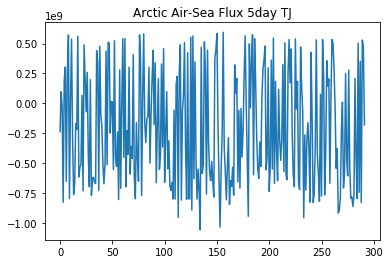

Sum of Air Sea flux -61559925084.2 TJ


In [23]:
# #Convert the watts/m2 to joules
# #multiply each time step by 432000 seconds or 5 days
# ascontrol_sumjoules = (ascontrol_sum*432000.0)
# plt.plot(np.arange(0,292),ascontrol_sumjoules/10**(12))

# plt.title('Arctic Air-Sea Flux 5day TJ')
# plt.show()
# s = np.sum(ascontrol_sumjoules)
# print('Sum of Air Sea flux',s/10**(12),'TJ')

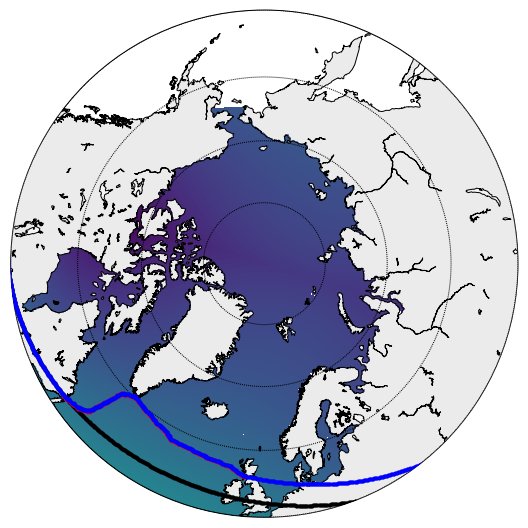

In [27]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,2,1)
m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='l',round='True',ax=ax)
m.drawcoastlines()
m.fillcontinents(color = '0.85',alpha=0.5)
m.drawparallels(np.arange(50.,90.,10.),labels=[True,True, True, True])
x_lon,y_lat=m(lon[:,:],lat[:,:])
cmap = plt.get_cmap('gray',25)
#mesh = m.pcolor(x_lon[:,:], y_lat[:,:],bathy[:,:],cmap=cmap)

m.plot(lon[329,:],lat[329,:],marker='.',color='black',latlon=True)
m.plot(OSNAPlon,OSNAPlat,marker='.',color='red',latlon=True)

m.plot(lon[329,:172],lat[329,:172],marker='.',color='blue',latlon=True)

m.pcolor(x_lon[:,:], y_lat[:,:], area)

for l1, l2 in zip(JJ, II):
    m.plot(lon[l1,l2],lat[l1,l2],marker='.',color='blue',latlon=True)

#for l1, l2 in zip(JJ, II):
 #   m.plot(lon[l1,l2],lat[l1,l2],marker='.',color='blue',latlon=True)
    
m.plot(lon[351,364:],lat[351,364:],marker='.',color='blue',latlon=True)

In [34]:
#sum the heat budget
#control
hb = cheat_in - ascontrol_sum/10**(12) - (deltac/10**(12))
print('Heat Budget',hb)

hb = sjheat_in - asslj_sum/10**(12) - (deltasj/10**(12))
print('Heat Budget',hb)

hb = pheat_in - aspolzin_sum/10**(12) - (deltap/10**(12))
print('Heat Budget',hb)

Heat Budget -5495739867.17
Heat Budget -4124120676.01
Heat Budget -5823181331.21
